<a href="https://colab.research.google.com/github/Nomaqui/Entrega_1_analisis_de_datos/blob/main/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importación de librerías y carga de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import requests
import io

# URL del CSV en formato RAW de GitHub
url = "https://raw.githubusercontent.com/Nomaqui/Entrega_1_analisis_de_datos/main/Dataset_Year_2019%20(1).csv"

# Descarga el archivo
response = requests.get(url)
if response.status_code == 200:
    content = response.content.decode('utf-8')
    # Detectar separador automáticamente
    if ";" in content.split("\n")[0]:
        sep = ";"
    elif "," in content.split("\n")[0]:
        sep = ","
    else:
        sep = "\t"  # asume tabulador si no hay , ni ;

    # Cargar a DataFrame
    df = pd.read_csv(io.StringIO(content), sep=sep)

df

,LOCATION,POWER,SELF-PROTECTION,Average earth discharge density DDT [Rays/km^2-año],Maximum ground discharge density DDT [Rays/km^2-año],Burning rate [Failures/year],Criticality according to previous study for ceramics level,Removable connectors,Type of clients,Number of users,Electric power not supplied EENS [kWh],Type of installation,Air network,Circuit Queue,km of network LT:,Burned transformers 2019
0,1,112.5,0,3.155602,6.6,0.00,0,1,STRATUM 2,94,1822.5,MACRO WITHOUT ANTI-FRAUD NET,1,0,0.32362,0
1,1,10.0,0,3.155602,6.6,0.00,0,1,OFFICIAL,1,270.0,MACRO WITHOUT ANTI-FRAUD NET,1,0,0.30036,0
2,1,25.0,0,3.155602,6.6,0.00,0,1,STRATUM 2,74,405.0,MACRO WITHOUT ANTI-FRAUD NET,1,0,0.29695,0
3,1,75.0,0,3.155602,6.6,0.00,0,1,STRATUM 6,30,1215.0,MACRO WITHOUT ANTI-FRAUD NET,1,0,0.12575,0
4,1,75.0,0,3.155602,6.6,0.00,0,1,STRATUM 4,24,1215.0,MACRO WITHOUT ANTI-FRAUD NET,1,1,0.16605,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15868,0,37.5,0,3.155602,6.6,0.00,0,0,STRATUM 1,30,796.5,POLE,1,0,0.80303,0
15869,0,37.5,0,4.148532,8.3,0.25,0,1,STRATUM 1,57,607.5,POLE,1,0,"146,419",0
15870,0,25.0,0,3.850980,6.1,0.00,0,0,STRATUM 1,21,855.0,POLE,1,1,0.7399,0
15871,0,10.0,0,0.717021,2.5,0.00,1,1,STRATUM 1,10,162.0,POLE,1,0,"176,708",0


Tratamiento de los datos

In [2]:
# Intentar convertir todas las columnas posibles a numéricas
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col].str.replace(",", "."), errors='ignore')
    except AttributeError:
        # Si no es string, ignora
        pass


# Identificación de variables numéricas y categóricas
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(exclude=np.number).columns

print("Variables numéricas:", list(num_cols))
print("Variables categóricas:", list(cat_cols))

# Seleccionar columnas numéricas y detectar binarias
numeric_cols = df.select_dtypes(include='number').columns
binary_cols = [col for col in numeric_cols if df[col].nunique() <= 2]
non_binary_cols = [col for col in numeric_cols if df[col].nunique() > 2]

# Calcular IQR inicial
Q1 = df[non_binary_cols].quantile(0.25)
Q3 = df[non_binary_cols].quantile(0.75)
IQR = Q3 - Q1

# Detectar outliers iniciales
outliers = ((df[non_binary_cols] < (Q1 - 1.5 * IQR)) | (df[non_binary_cols] > (Q3 + 1.5 * IQR)))
cols_con_outliers = outliers.sum()[outliers.sum() > 0].index  # columnas con outliers

# Reemplazar outliers con mediana SOLO en columnas con outliers
df_clean = df.copy()
for col in cols_con_outliers:
    lower_bound = Q1[col] - 1.5 * IQR[col]
    upper_bound = Q3[col] + 1.5 * IQR[col]
    median_value = df[col].median()
    df_clean[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound),
                             median_value,
                             df[col])

# Recalcular outliers después del reemplazo
Q1_clean = df_clean[non_binary_cols].quantile(0.25)
Q3_clean = df_clean[non_binary_cols].quantile(0.75)
IQR_clean = Q3_clean - Q1_clean
outliers_after = ((df_clean[non_binary_cols] < (Q1_clean - 1.5 * IQR_clean)) |
                  (df_clean[non_binary_cols] > (Q3_clean + 1.5 * IQR_clean)))

cols_con_outliers_after = outliers_after.sum()[outliers_after.sum() > 0].index

# Crear listas finales
ignored_due_to_binary = binary_cols
ignored_due_to_outliers = list(cols_con_outliers_after)
final_analyzed_cols = [col for col in non_binary_cols if col not in ignored_due_to_outliers]

# Imprimir resultados
print("\n Columnas ignoradas por ser binarias:")
print(ignored_due_to_binary)

print("\n Columnas ignoradas porque siguieron con outliers ≠ 0 después del reemplazo:")
print(ignored_due_to_outliers)

print("\n Columnas finales analizadas (limpias):")
print(final_analyzed_cols)

df_clean

/tmp/ipython-input-3176170640.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col].str.replace(",", "."), errors='ignore')


Variables numéricas: ['LOCATION', 'POWER', 'SELF-PROTECTION', 'Average earth discharge density DDT [Rays/km^2-año]', 'Maximum ground discharge density DDT [Rays/km^2-año]', 'Burning rate  [Failures/year]', 'Criticality according to previous study for ceramics level', 'Removable connectors', 'Number of users', 'Electric power not supplied EENS [kWh] ', 'Air network', 'Circuit Queue', 'km of network LT:', 'Burned transformers 2019']
Variables categóricas: ['Type of clients', 'Type of installation']

 Columnas ignoradas por ser binarias:
['LOCATION', 'SELF-PROTECTION', 'Criticality according to previous study for ceramics level', 'Removable connectors', 'Air network', 'Circuit Queue', 'Burned transformers 2019']

 Columnas ignoradas porque siguieron con outliers ≠ 0 después del reemplazo:
['POWER', 'Number of users', 'Electric power not supplied EENS [kWh] ', 'km of network LT:']

 Columnas finales analizadas (limpias):
['Average earth discharge density DDT [Rays/km^2-año]', 'Maximum grou

,LOCATION,POWER,SELF-PROTECTION,Average earth discharge density DDT [Rays/km^2-año],Maximum ground discharge density DDT [Rays/km^2-año],Burning rate [Failures/year],Criticality according to previous study for ceramics level,Removable connectors,Type of clients,Number of users,Electric power not supplied EENS [kWh],Type of installation,Air network,Circuit Queue,km of network LT:,Burned transformers 2019
0,1,15.0,0,3.155602,6.6,0.0,0,1,STRATUM 2,13.0,399.6,MACRO WITHOUT ANTI-FRAUD NET,1,0,0.32362,0
1,1,10.0,0,3.155602,6.6,0.0,0,1,OFFICIAL,1.0,270.0,MACRO WITHOUT ANTI-FRAUD NET,1,0,0.30036,0
2,1,25.0,0,3.155602,6.6,0.0,0,1,STRATUM 2,13.0,405.0,MACRO WITHOUT ANTI-FRAUD NET,1,0,0.29695,0
3,1,15.0,0,3.155602,6.6,0.0,0,1,STRATUM 6,30.0,1215.0,MACRO WITHOUT ANTI-FRAUD NET,1,0,0.12575,0
4,1,15.0,0,3.155602,6.6,0.0,0,1,STRATUM 4,24.0,1215.0,MACRO WITHOUT ANTI-FRAUD NET,1,1,0.16605,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15868,0,37.5,0,3.155602,6.6,0.0,0,0,STRATUM 1,30.0,796.5,POLE,1,0,0.80303,0
15869,0,37.5,0,4.148532,8.3,0.0,0,1,STRATUM 1,57.0,607.5,POLE,1,0,146.41900,0
15870,0,25.0,0,3.850980,6.1,0.0,0,0,STRATUM 1,21.0,855.0,POLE,1,1,0.73990,0
15871,0,10.0,0,0.717021,2.5,0.0,1,1,STRATUM 1,10.0,162.0,POLE,1,0,176.70800,0


En el análisis de datos, se decidió ignorar cuatro columnas que continuaban presentando outliers incluso después del reemplazo por la mediana.

POWER: se excluyó debido a que representa la potencia nominal de referencia del transformador, un valor característico de diseño que puede variar ampliamente entre equipos, por lo que no es adecuado normalizarlo.

Number of users: se descartó porque la cantidad de usuarios conectados a cada transformador puede variar drásticamente entre zonas rurales y urbanas, generando sesgos en el análisis.

Electric power not supplied EENS [kWh]: se ignoró debido a que presenta valores con gran variabilidad y alto nivel de precisión decimal, lo que puede distorsionar la detección de patrones.

km of network LT: se omitió por el mismo motivo, ya que su alta precisión decimal y la amplitud de su rango de valores afectan la consistencia del análisis.

Con esta depuración, se prioriza el uso de variables más representativas y homogéneas para el modelo de análisis.

Escalamiento y codificacion

In [3]:
scaler = StandardScaler()
df_clean[num_cols] = scaler.fit_transform(df_clean[num_cols])

if len(cat_cols) > 0:
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded = encoder.fit_transform(df_clean[cat_cols])
    encoded_cols = encoder.get_feature_names_out(cat_cols)
    df_clean = pd.concat([df_clean.drop(columns=cat_cols), pd.DataFrame(encoded, columns=encoded_cols)], axis=1)


Selección de características (Feature Selection)

In [4]:
#Ajusta el nombre de la columna objetivo
target = 'Burned transformers 2019'
X = df_clean.drop(columns=[target])
y = df_clean[target]

# SelectKBest (10 características más relevantes)
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

print("Variables más relevantes según SelectKBest:")
print(selected_features)


Variables más relevantes según SelectKBest:
Index(['LOCATION', 'POWER', 'SELF-PROTECTION', 'Removable connectors',
       'Number of users', 'Electric power not supplied EENS [kWh] ',
       'Type of clients_STRATUM 1', 'Type of clients_STRATUM 2',
       'Type of installation_EN H',
       'Type of installation_MACRO WITHOUT ANTI-FRAUD NET'],
      dtype='object')


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [5] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Importancia de variables con Random Forest

In [5]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

print(importances.head(10))

km of network LT:                                             0.306322
Number of users                                               0.133346
Electric power not supplied EENS [kWh]                        0.121482
SELF-PROTECTION                                               0.091549
Average earth discharge density DDT [Rays/km^2-año]           0.083347
Maximum ground discharge density DDT [Rays/km^2-año]          0.074808
Removable connectors                                          0.055099
POWER                                                         0.039020
Circuit Queue                                                 0.030208
Criticality according to previous study for ceramics level    0.018647
dtype: float64


Reducción de dimensionalidad PCA

PCA redujo de 28 a 12 componentes principales
Varianza explicada acumulada: 0.9667356482392091


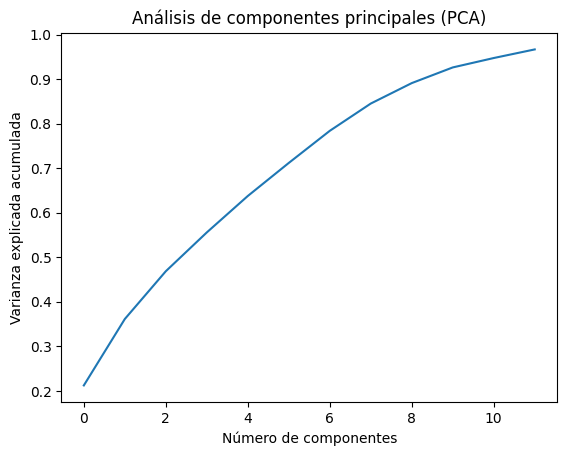

In [6]:
pca = PCA(n_components=0.95)  # conserva el 95% de la varianza
X_pca = pca.fit_transform(X)

print(f"PCA redujo de {X.shape[1]} a {pca.n_components_} componentes principales")
print("Varianza explicada acumulada:", sum(pca.explained_variance_ratio_))

# Gráfico de varianza
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.title("Análisis de componentes principales (PCA)")
plt.show()

Conclusiones

- Se aplicó escalamiento y codificación para normalizar los datos y transformar variables categóricas.
- La técnica SelectKBest permitió identificar las variables con mayor relación con la variable objetivo.
- Con Random Forest, se confirmó la relevancia de las mismas variables seleccionadas estadísticamente.
- El análisis PCA permitió reducir la dimensionalidad conservando el 95% de la varianza, facilitando un modelo más eficiente.
- Este proceso optimiza el rendimiento del modelo y elimina variables redundantes o ruidosas.